In [1]:
import os
import pickle
import random
import numpy as np
import xarray as xr
import pandas as pd
import deepsensor.torch
import cartopy.crs as ccrs
from tqdm import tqdm_notebook
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from deepsensor.data import TaskLoader, DataProcessor
from deepsensor.train import set_gpu_default_device, Trainer
from deepsensor.model import ConvNP

In [2]:
set_gpu_default_device()

In [3]:
india_ds = xr.open_dataset('wustl_dataset.nc')
india_ds

<xarray.Dataset> Size: 115MB
Dimensions:  (time: 264, lat: 340, lon: 320)
Coordinates:
  * time     (time) datetime64[ns] 2kB 1998-01-01 1998-02-01 ... 2019-12-01
  * lat      (lat) float32 1kB 5.05 5.15 5.25 5.35 ... 38.65 38.75 38.85 38.95
  * lon      (lon) float32 1kB 67.05 67.15 67.25 67.35 ... 98.75 98.85 98.95
Data variables:
    PM25     (time, lat, lon) float32 115MB ...
Attributes:
    TITLE:            Convolutional Neural Network Monthly PM2.5 Estimation o...
    CONTACT:          SIYUAN SHEN <s.siyuan@wustl.edu>
    LAT_DELTA:        0.1
    LON_DELTA:        0.1
    SPATIALCOVERAGE:  AS
    TIMECOVERAGE:     201206

In [4]:
data_processor = DataProcessor('data/data_processor_config/')
print(data_processor)

DataProcessor with normalisation params:
{'PM25': {'method': 'mean_std',
          'params': {'mean': 23.592239379882812, 'std': 20.73126792907715}},
 'coords': {'time': {'name': 'time'},
            'x1': {'map': (5.050000190734863, 38.95000076293945),
                   'name': 'lat'},
            'x2': {'map': (67.05000305175781, 100.95000457763672),
                   'name': 'lon'}}}


In [5]:
scaled_train_ds = xr.open_dataset('data/scaled_train_data.nc')
scaled_val_ds = xr.open_dataset('data/scaled_val_data.nc')

In [6]:
task_loader = TaskLoader(context=scaled_train_ds,target=scaled_train_ds)
task_loader.load_dask()

In [7]:
val_tasks = []
val_tasks_path = 'data/val_tasks'
for context_folder in os.listdir(val_tasks_path):
    for task_file in os.listdir(f'{val_tasks_path}/{context_folder}'):
        
        with open(f'{val_tasks_path}/{context_folder}/{task_file}','rb') as f:
            val_tasks.extend(pickle.load(f))

In [30]:
model = ConvNP(data_processor,task_loader,likelihood='gnp',unet_channels=(32,32,32,32,32))

dim_yc inferred from TaskLoader: (1,)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 339
encoder_scales inferred from TaskLoader: [np.float32(0.0014749259)]
decoder_scale inferred from TaskLoader: 0.0029498525073746312


In [9]:
def gen_tasks(dates, task_loader=None, N_c=None, N_t=None):

    """
    Generates tasks for the specified dates
    """
    assert task_loader is not None
    tasks = []
    for date in dates:

        if N_c is None:
            N_c = np.random.randint(5,501)      # Randomly sampling [0,500] points as context set

        # if N_t is None:
            # N_t = np.random.randint(3000,5001)  # Randomly sampling [3000,5000] points as target set

        task = task_loader(date, context_sampling = N_c, target_sampling = "all")

        tasks.append(task)

    return tasks

In [10]:
def calculate_val_rmse(model, val_tasks):
    errors = []
    target_var_id = task_loader.target_var_IDs[0][0]

    for task in val_tasks:
        pred = data_processor.map_array(model.mean(task), target_var_id, unnorm=True)
        true = data_processor.map_array(task['Y_t'][0], target_var_id, unnorm=True)

        errors.append(np.abs(true-pred))
    
    return np.sqrt(np.mean(np.concatenate(errors)**2))

In [11]:
train_start, train_end = "1998-01-01", "2008-12-01"

In [31]:
epoch_losses = []
val_rmses = []

In [32]:
trainer = Trainer(model,lr=6e-6)
for epoch in tqdm_notebook(range(200)):
    iter_losses = []
    for iteration in range(120):

        date = random.choice(scaled_train_ds.time.values) 

        N_c = np.random.randint(5,501)
        task = task_loader(date, context_sampling=N_c, target_sampling="all")

        loss = trainer([task])
        iter_losses.append(loss)
    
    val_rmses.append(calculate_val_rmse(model,val_tasks))
    
    epoch_losses.append(np.mean(iter_losses))
               

/tmp/ipykernel_53753/4114246660.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(200)):


  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
def plot_training_losses(epoch_losses,val_rmses):
    fig, axes = plt.subplots(1,2,figsize=(12,4))
    axes[0].plot(epoch_losses)
    axes[1].plot(val_rmses)
    _ = axes[0].set_xlabel("Epoch")
    _ = axes[1].set_xlabel("Epoch")
    _ = axes[0].set_title("Training loss")
    _ = axes[1].set_title("Validation RMSE")

    plt.show()
plot_training_losses(epoch_losses,val_rmses)

In [ ]:
plot_training_losses(epoch_losses,val_rmses)

## Let's tune the parameters

### 1) learning rates

In [18]:
learning_rates = [6e-6, 2e-5, 4e-5, 6e-5, 8e-5, 1e-4]

In [19]:
hyper_param_lr = dict()

In [20]:
val_task_loader = TaskLoader(context=scaled_val_ds,target=scaled_val_ds)
val_task_loader.load_dask()

def predict(dates, N_c):
    pred_tasks = gen_tasks(dates,task_loader=val_task_loader,N_c=N_c)
    pred = model.predict(pred_tasks,X_t=india_ds)

    return pred

def val_rmse():
    context_points = np.arange(5,500,10)
    pred_dates = pd.date_range("2009-01-01","2010-12-01",freq='MS')
    RMSE = []
    # progress_bar = tqdm(total=len(context_points))

    for point in context_points:
        pred = predict(pred_dates,point)

        true = india_ds.sel(time=slice("2009-01-01","2010-12-01"))

        curr_rmse = (np.sqrt(((true['PM25']-pred[0]['mean']).values)**2)).mean()
        RMSE.append(curr_rmse)

        # progress_bar.update(1)
    return RMSE

dim_yc inferred from TaskLoader: (1,)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 339
encoder_scales inferred from TaskLoader: [np.float32(0.0014749259)]
decoder_scale inferred from TaskLoader: 0.0029498525073746312



Learning Rate = 6e-06


/tmp/ipykernel_53753/1512413176.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(100)):


  0%|          | 0/100 [00:00<?, ?it/s]

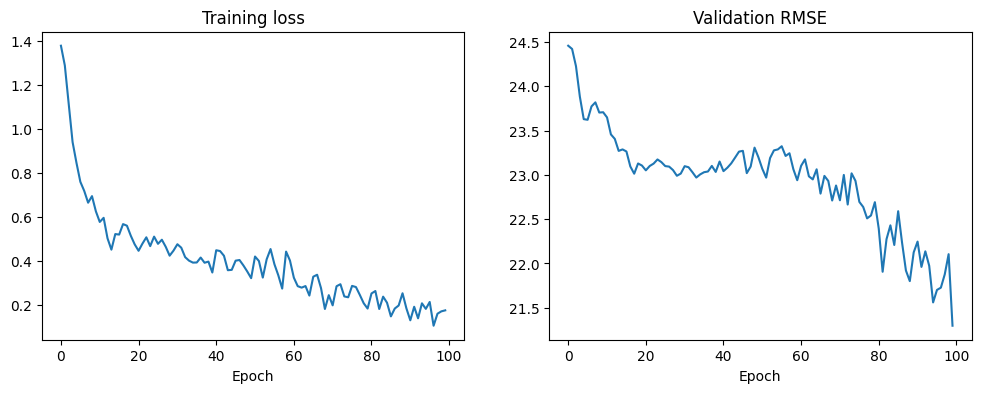

dim_yc inferred from TaskLoader: (1,)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 339
encoder_scales inferred from TaskLoader: [np.float32(0.0014749259)]
decoder_scale inferred from TaskLoader: 0.0029498525073746312



Learning Rate = 2e-05


/tmp/ipykernel_53753/1512413176.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(100)):


  0%|          | 0/100 [00:00<?, ?it/s]

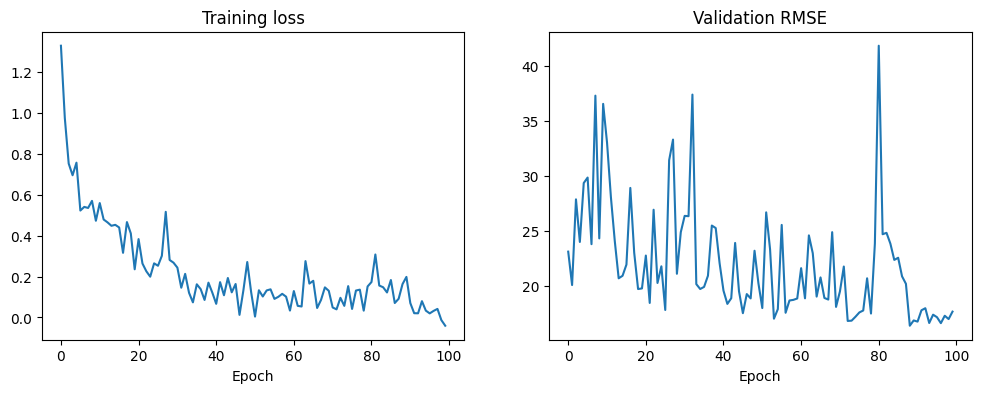

dim_yc inferred from TaskLoader: (1,)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 339
encoder_scales inferred from TaskLoader: [np.float32(0.0014749259)]
decoder_scale inferred from TaskLoader: 0.0029498525073746312



Learning Rate = 4e-05


/tmp/ipykernel_53753/1512413176.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(100)):


  0%|          | 0/100 [00:00<?, ?it/s]

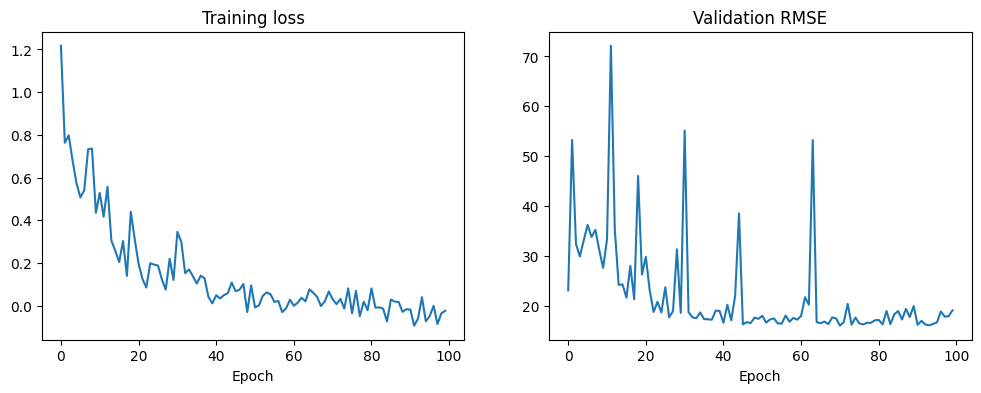

dim_yc inferred from TaskLoader: (1,)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 339
encoder_scales inferred from TaskLoader: [np.float32(0.0014749259)]
decoder_scale inferred from TaskLoader: 0.0029498525073746312



Learning Rate = 6e-05


/tmp/ipykernel_53753/1512413176.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(100)):


  0%|          | 0/100 [00:00<?, ?it/s]

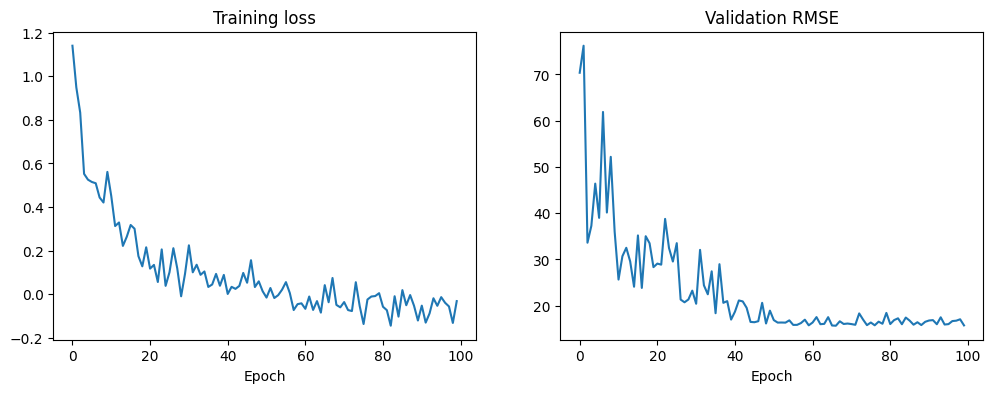

dim_yc inferred from TaskLoader: (1,)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 339
encoder_scales inferred from TaskLoader: [np.float32(0.0014749259)]
decoder_scale inferred from TaskLoader: 0.0029498525073746312



Learning Rate = 8e-05


/tmp/ipykernel_53753/1512413176.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(100)):


  0%|          | 0/100 [00:00<?, ?it/s]

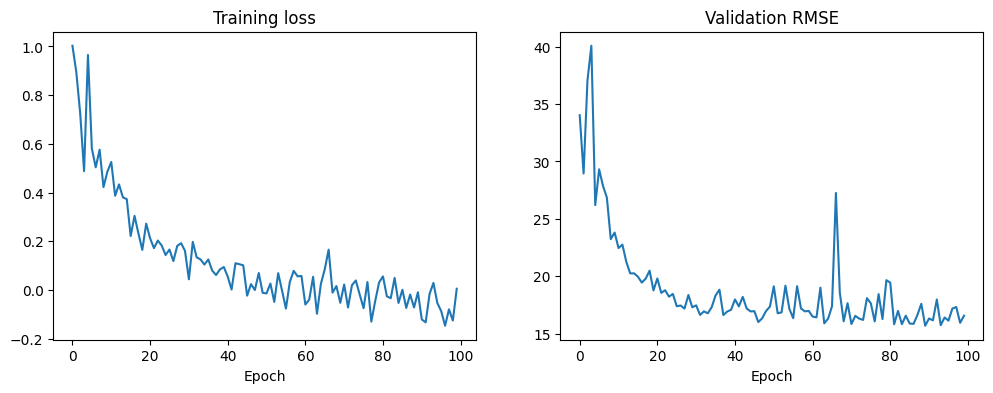

dim_yc inferred from TaskLoader: (1,)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 339
encoder_scales inferred from TaskLoader: [np.float32(0.0014749259)]
decoder_scale inferred from TaskLoader: 0.0029498525073746312



Learning Rate = 0.0001


/tmp/ipykernel_53753/1512413176.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(100)):


  0%|          | 0/100 [00:00<?, ?it/s]

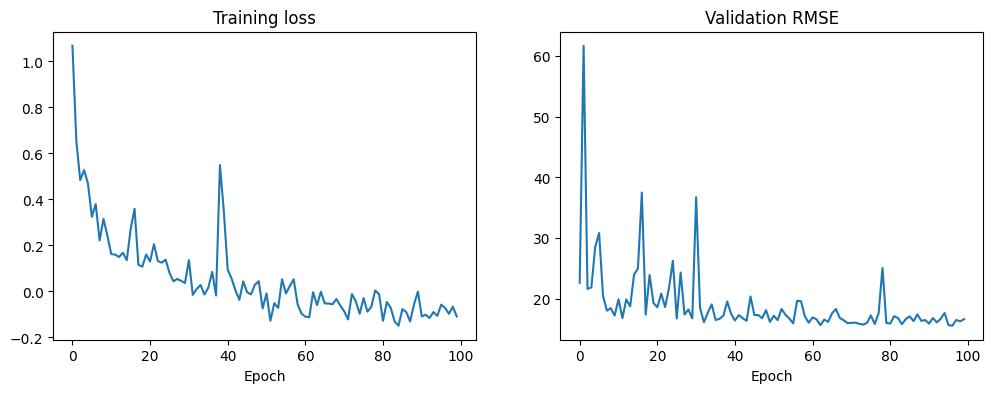

In [21]:
for lr in learning_rates:

    model = ConvNP(data_processor,task_loader,likelihood='gnp',unet_channels=(32,32,32,32,32))
    print('\n\n')
    epoch_losses = []
    val_rmses = []

    trainer = Trainer(model,lr=lr)
    print(f"Learning Rate = {lr}")
    for epoch in tqdm_notebook(range(100)):
        iter_losses = []
        for iteration in range(120):

            date = random.choice(scaled_train_ds.time.values) 

            N_c = np.random.randint(5,501)
            task = task_loader(date, context_sampling=N_c, target_sampling="all")

            loss = trainer([task])
            iter_losses.append(loss)
        
        val_rmses.append(calculate_val_rmse(model,val_tasks))
        
        epoch_losses.append(np.mean(iter_losses))
    plot_training_losses(epoch_losses,val_rmses)

    hyper_param_lr[lr] = val_rmse()

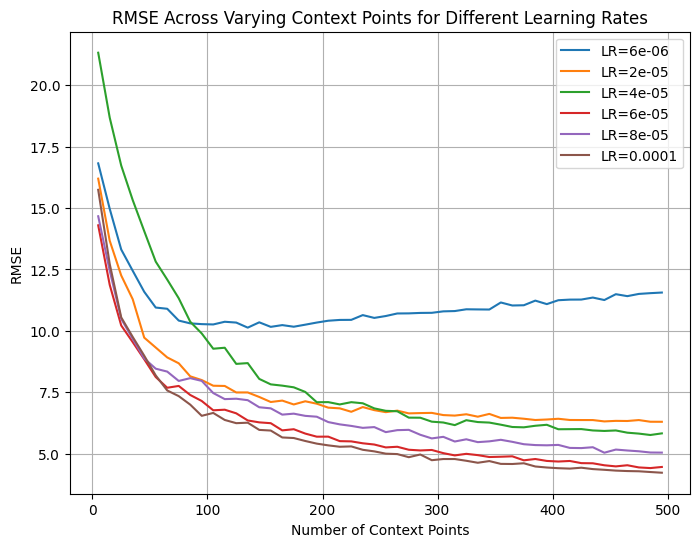

In [36]:
context_points = np.arange(5, 500, 10)  

plt.figure(figsize=(8, 6))

for lr, errors in hyper_param_lr.items():
    plt.plot(context_points, errors, label=f'LR={lr}')  

plt.xlabel('Number of Context Points')
plt.ylabel('RMSE')
plt.title('RMSE Across Varying Context Points for Different Learning Rates')
plt.legend() 
plt.grid(True)  
plt.show()


In [35]:
import pickle

with open("errors.pkl", "wb") as f:
    pickle.dump(hyper_param_lr, f)


In [17]:
# val_rmse_best = np.inf
# patience = 10
# trainer = Trainer(model, lr = 5e-6)

# for epoch in tqdm_notebook(range(100)):
    
#     train_dates = pd.date_range(train_start, train_end, freq = "MS")
#     train_tasks = gen_tasks(train_dates)
#     batch_losses = trainer(train_tasks)

#     losses.append(np.mean(batch_losses))
#     val_rmses.append(calculate_val_rmse(model, val_tasks))

#     if val_rmses[-1] < val_rmse_best:
#         patience = 10
#         val_rmse_best = val_rmses[-1]
#         # model.save('deepsensor_config/')
#     else:
#         patience -= 1    # If there is no improvemnet, reduce the counter by 1
#     if patience == 0:
#         break            # If there is no improvement uptill 5 epochs, stop the training